## <center>1st Kaggle competition : digit recognizer</center>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
import random
from xgboost import XGBClassifier
from time import time
from tensorflow.python.keras.utils import np_utils, to_categorical
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.keras.constraints import maxnorm
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

C:\Users\aline.debenath\AppData\Local\Continuum\anaconda3\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\aline.debenath\AppData\Local\Continuum\anaconda3\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\aline.debenath\AppData\Local\Continuum\anaconda3\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'

In [19]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
data.isnull().any().sum()

0

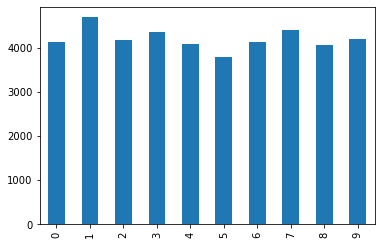

In [21]:
data.label.value_counts().sort_index().plot(kind='bar')

In [22]:
train_data=(data.drop(columns='label')).values
labeled_data_num=(data.label).values
labeled_data=to_categorical(labeled_data_num)
train_data0 = train_data.reshape(train_data.shape[0], 28, 28)

<function matplotlib.pyplot.show(*args, **kw)>

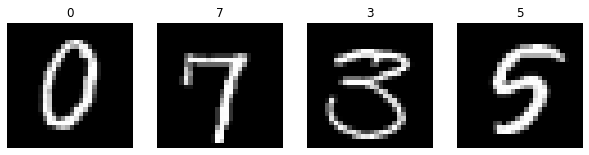

In [23]:
plt.figure(figsize=(13,13))
for i in range(5, 9):
    plt.subplot(450 + (i+1))
    plt.imshow(train_data0[i], cmap=plt.get_cmap('gray'))
    plt.title(labeled_data_num[i])
    plt.axis('off')
plt.show

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='label'), data.label, test_size=0.2, random_state=2)

In [ ]:
rfc  = RandomForestClassifier(n_estimators = 300,criterion= 'gini', max_depth= 5, max_features=9)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
accuracy_score(y_test, rfc_pred)

## XGBoost 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='label'), data.label, test_size=0.2, random_state=2)

In [ ]:
xgb=XGBClassifier(objective='multi:softmax', num_class=10, 
        n_jobs=-1,booster="gbtree",tree_method = "hist",
        grow_policy = "depthwise")
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
accuracy_score(y_test, xgb_pred)

## Deep learning : neural network 

### Pre-processing 

In [26]:
# Read data
train = pd.read_csv('train.csv')

X_train = (train.drop(columns='label').values).astype('float32')
X_test = (pd.read_csv('test.csv').values).astype('float32')
y_test=(pd.read_csv('test.csv').values).astype('int32')
# convert list of labels to binary class matrix
labels = train.label.values.astype('int32')
y_train = np_utils.to_categorical(labels) 

# pre-processing: divide by max and substract mean
scale = np.max(X_train)
X_train /= scale
X_test /= scale

mean = np.std(X_train)
X_train -= mean
X_test -= mean

input_dim = X_train.shape[1]
nb_classes = y_train.shape[1]

### Grid search for epochs and batch size

In [28]:
def create_model():
	# create model
	model = Sequential()
	model.add(Dense(128, input_dim=input_dim,kernel_initializer='he_uniform',kernel_constraint=maxnorm(1)))
	model.add(Activation('softsign'))
	model.add(Dropout(0.1))
	model.add(Dense(128, kernel_initializer='he_uniform',kernel_constraint=maxnorm(2)))
	model.add(Activation('relu'))
	model.add(Dropout(0.1))
	model.add(Dense(nb_classes))
	model.add(Activation('softplus'))
	model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])
	return model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 30, 85, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best batch size and epochs: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.974881 using {'batch_size': 85, 'epochs': 100}
0.961952 (0.004182) with: {'batch_size': 10, 'epochs': 10}
0.969238 (0.003714) with: {'batch_size': 10, 'epochs': 50}
0.974286 (0.001165) with: {'batch_size': 10, 'epochs': 100}
0.964048 (0.002397) with: {'batch_size': 30, 'epochs': 10}
0.969571 (0.002177) with: {'batch_size': 30, 'epochs': 50}
0.974690 (0.000453) with: {'batch_size': 30, 'epochs': 100}
0.962214 (0.000631) with: {'batch_size': 85, 'epochs': 10}
0.972905 (0.000819) with: {'batch_size': 85, 'epochs': 50}
0.974881 (0.001352) with: {'batch_size': 85, 'epochs': 100}
0.961167 (0.001952) with: {'batch_size': 100, 'epochs': 10}
0.972381 (0.001318) with: {'batch_size': 100, 'epochs': 50}
0.974738 (0.002171) with: {'batch_size': 100, 'epochs': 100}


### Grid search for optimizer

In [33]:
#Grid search for optimizer
def create_model(optimizer='adam'):
	# create model
	model = Sequential()
	model.add(Dense(128, input_dim=input_dim,kernel_initializer='lecun_uniform',
                    kernel_constraint=maxnorm(2)))
	model.add(Activation('softsign'))
	model.add(Dropout(0.1))
	model.add(Dense(128,kernel_initializer='lecun_uniform',kernel_constraint=maxnorm(1)))
	model.add(Activation('relu'))
	model.add(Dropout(0.1))
	model.add(Dense(nb_classes))
	model.add(Activation('softplus'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model
model = KerasClassifier(build_fn=create_model, epochs=85, batch_size=100, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best optimizer: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best optimizer: 0.974952 using {'optimizer': 'Adadelta'}
0.949786 (0.002838) with: {'optimizer': 'SGD'}
0.973238 (0.001082) with: {'optimizer': 'RMSprop'}
0.971048 (0.001247) with: {'optimizer': 'Adagrad'}
0.974952 (0.000713) with: {'optimizer': 'Adadelta'}
0.974381 (0.001102) with: {'optimizer': 'Adam'}
0.973548 (0.001604) with: {'optimizer': 'Adamax'}
0.970857 (0.001462) with: {'optimizer': 'Nadam'}


### Grid search for activation

In [ ]:
def create_model(activation='relu'):
	# create model
	model = Sequential()
	model.add(Dense(128, input_dim=input_dim,kernel_initializer='he_uniform',
                kernel_constraint=maxnorm(2), activation=activation))
	model.add(Dropout(0.1))
	model.add(Dense(128,kernel_initializer='lecun_uniform',kernel_constraint=maxnorm(1)))
	model.add(Activation('relu'))
	model.add(Dropout(0.1))
	model.add(Dense(nb_classes))
	model.add(Activation('softplus'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
	return model
model = KerasClassifier(build_fn=create_model, epochs=85, batch_size=100, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best optimizer: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
## BEST
train = pd.read_csv('train.csv')
labels = train.label.values.astype('int32')
X_train = (train.drop(columns='label').values).astype('float32')
X_test = (pd.read_csv('test.csv').values).astype('float32')

# convert list of labels to binary class matrix
y_train = np_utils.to_categorical(labels) 

# pre-processing: divide by max and substract mean
scale = np.max(X_train)
X_train /= scale
X_test /= scale

mean = np.std(X_train)
X_train -= mean
X_test -= mean

input_dim = X_train.shape[1]
nb_classes = y_train.shape[1]
model = Sequential()
model.add(Dense(128, input_dim=input_dim,kernel_initializer='he_uniform',kernel_constraint=maxnorm(1)))
model.add(Activation('softsign'))
model.add(Dropout(0.1))
model.add(Dense(128, kernel_initializer='he_uniform',kernel_constraint=maxnorm(2)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(nb_classes))
model.add(Activation('softplus'))
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])
print("Training...")
model.fit(X_train, y_train, epochs=85, batch_size=100, validation_split=0.1, verbose=2)